# Анализ данных управления затратами

Этот notebook содержит полный анализ данных из файла `cost_management_survey_results_10000.csv`, включая:
1. Загрузку и первичный анализ данных
2. Очистку от пустых значений
3. Загрузку в PostgreSQL
4. Создание аналитических витрин
5. Подготовку данных для DataLens


In [1]:
!pip install psycopg2-binary
!pip install seaborn
!pip install sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 29.8 MB/s eta 0:00:00


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## 1. Загрузка и первичный анализ данных


In [8]:
# Загрузка данных из CSV
df = pd.read_csv('survey_responses.csv')

print(f"Размер датасета: {df.shape}")
print(f"Количество записей: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")
print("\nПервые 5 строк:")
df.head()


Размер датасета: (1000, 11)
Количество записей: 1000
Количество столбцов: 11

Первые 5 строк:


,respondent_id,timestamp,department,systems_used,efficiency,practices,storage_cost_share_pct,automation_level,budget_deviation_pct,maturity_level,key_metrics
0,1,2025-10-08 16:00:00,Разработка / Продукты,"Облачные решения (Yandex Cloud, AWS, GCP)",эффективно,Автоматическое масштабирование,32.7,полностью автоматизировано,17.0,установленные процессы,Cost per GB хранения
1,2,2025-10-06 22:00:00,Разработка / Продукты,"BI-платформы (DataLens, Power BI, Tableau)",скорее неэффективно,FinOps-подход,46.1,частично автоматизировано,10.6,развивающийся,Cost per GB хранения
2,3,2025-10-13 02:00:00,Аналитика / Data Science,Гибридные (облако + локально),скорее неэффективно,Не применяются,27.7,полностью автоматизировано,18.5,системный подход,Стоимость лицензий BI
3,4,2025-10-08 03:00:00,Финансы / Контроллинг,Другое,эффективно,Не применяются,33.8,частично вручную,27.2,системный подход,Query cost per user
4,5,2025-10-24 07:00:00,Аналитика / Data Science,Озеро данных (Data Lake),эффективно,Централизация отчётности,34.9,в основном автоматизировано,9.7,начальный уровень,SLA penalties / downtime cost


In [9]:
# Анализ структуры данных
print("Информация о столбцах:")
print(df.info())
print("\nОписательная статистика:")
df.describe()


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   respondent_id           1000 non-null   int64  
 1   timestamp               1000 non-null   object 
 2   department              1000 non-null   object 
 3   systems_used            1000 non-null   object 
 4   efficiency              1000 non-null   object 
 5   practices               1000 non-null   object 
 6   storage_cost_share_pct  1000 non-null   float64
 7   automation_level        1000 non-null   object 
 8   budget_deviation_pct    1000 non-null   float64
 9   maturity_level          1000 non-null   object 
 10  key_metrics             1000 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 86.1+ KB
None

Описательная статистика:


,respondent_id,storage_cost_share_pct,budget_deviation_pct
count,1000.000000,1000.000000,1000.000000
mean,500.500000,30.070700,12.364000
std,288.819436,11.750393,12.594494
min,1.000000,0.000000,-46.500000
25%,250.750000,22.700000,5.475000
50%,500.500000,29.600000,12.200000
75%,750.250000,37.150000,18.500000
max,1000.000000,100.000000,131.000000


In [11]:
# Проверка на пропущенные значения
print("Пропущенные значения по столбцам:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})

print(missing_df[missing_df['Количество пропусков'] > 0])

# Общая статистика по пропускам
total_missing = df.isnull().sum().sum()
print(f"\nОбщее количество пропущенных значений: {total_missing}")
print(f"Процент пропущенных значений: {(total_missing / (len(df) * len(df.columns))) * 100:.2f}%")


Пропущенные значения по столбцам:
Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []

Общее количество пропущенных значений: 0
Процент пропущенных значений: 0.00%


In [12]:
# Анализ уникальных значений в категориальных столбцах
categorical_columns = ['department', 'systems_used', 'efficiency', 'practices', 'key_metrics']

print("Уникальные значения в категориальных столбцах:")
for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} уникальных значений")
    print(df[col].value_counts().head(10))


Уникальные значения в категориальных столбцах:

department: 7 уникальных значений
department
IT / Инфраструктура                247
Разработка / Продукты              218
Аналитика / Data Science           183
Финансы / Контроллинг              161
Операции / Бизнес-подразделение     89
Руководство / Менеджмент            53
Другое                              49
Name: count, dtype: int64

systems_used: 6 уникальных значений
systems_used
Озеро данных (Data Lake)                      186
Другое                                        171
BI-платформы (DataLens, Power BI, Tableau)    167
Облачные решения (Yandex Cloud, AWS, GCP)     166
Гибридные (облако + локально)                 165
Локальные (on-premise) решения                145
Name: count, dtype: int64

efficiency: 5 уникальных значений
efficiency
умеренно                  339
эффективно                321
скорее неэффективно       161
максимально эффективно    131
неэффективно               48
Name: count, dtype: int64

practices

## 2. Визуализация данных


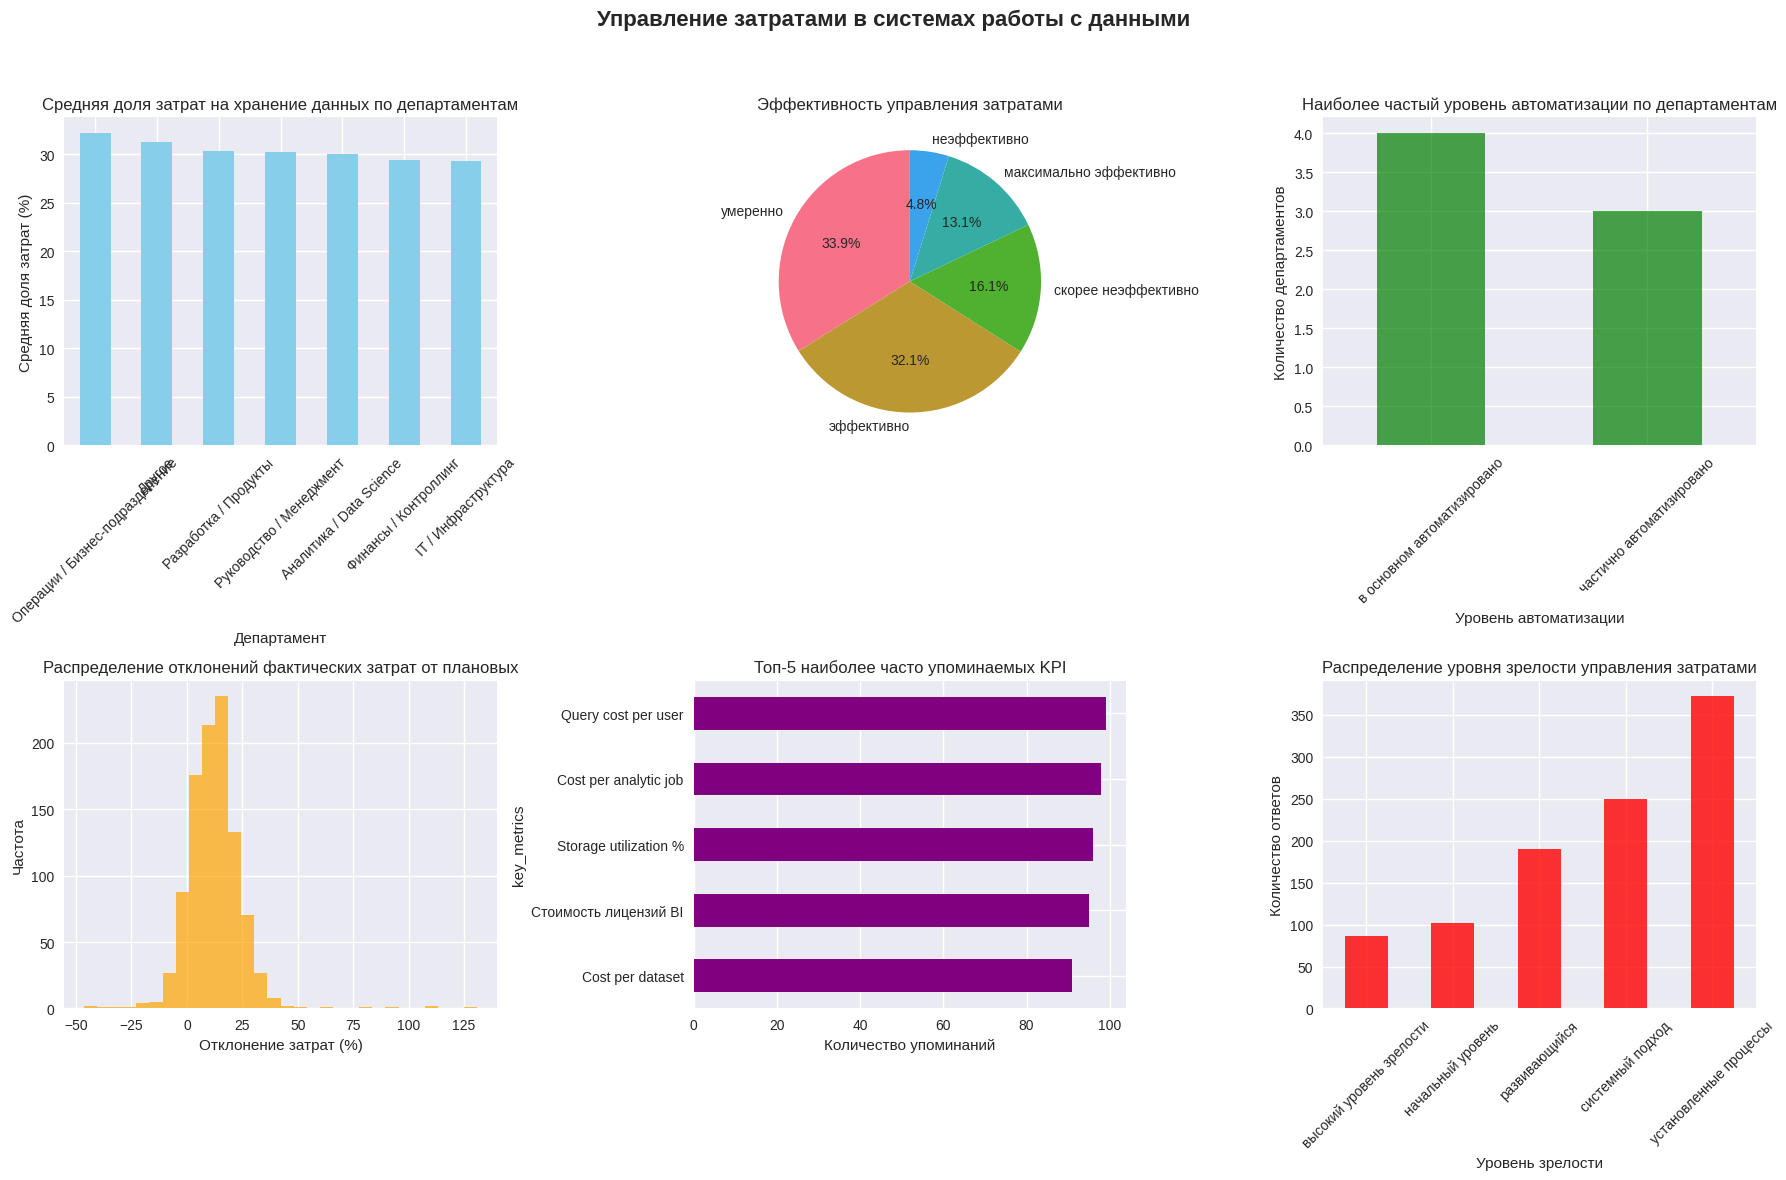

In [16]:
# Создание визуализаций
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Управление затратами в системах работы с данными', fontsize=16, fontweight='bold')

# 1. Общие затраты на хранение данных по департаментам
df.groupby('department')['storage_cost_share_pct'].mean().sort_values(ascending=False).plot(
    kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Средняя доля затрат на хранение данных по департаментам')
axes[0,0].set_xlabel('Департамент')
axes[0,0].set_ylabel('Средняя доля затрат (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Эффективность управления затратами
eff_counts = df['efficiency'].value_counts()
axes[0,1].pie(eff_counts.values, labels=eff_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Эффективность управления затратами')

# 3. Уровень автоматизации по департаментам
automation_by_dept = df.groupby('department')['automation_level'].apply(lambda x: x.value_counts().idxmax())
automation_by_dept.value_counts().plot(kind='bar', ax=axes[0,2], color='green', alpha=0.7)
axes[0,2].set_title('Наиболее частый уровень автоматизации по департаментам')
axes[0,2].set_xlabel('Уровень автоматизации')
axes[0,2].set_ylabel('Количество департаментов')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Распределение отклонений бюджета
axes[1,0].hist(df['budget_deviation_pct'], bins=30, color='orange', alpha=0.7)
axes[1,0].set_title('Распределение отклонений фактических затрат от плановых')
axes[1,0].set_xlabel('Отклонение затрат (%)')
axes[1,0].set_ylabel('Частота')

# 5. Топ-5 наиболее упоминаемых метрик / KPI
top_kpis = df['key_metrics'].value_counts().head(5)
top_kpis.plot(kind='barh', ax=axes[1,1], color='purple')
axes[1,1].set_title('Топ-5 наиболее часто упоминаемых KPI')
axes[1,1].set_xlabel('Количество упоминаний')
axes[1,1].invert_yaxis()

# 6. Распределение уровней зрелости управления затратами
maturity_counts = df['maturity_level'].value_counts().sort_index()
maturity_counts.plot(kind='bar', ax=axes[1,2], color='red', alpha=0.8)
axes[1,2].set_title('Распределение уровня зрелости управления затратами')
axes[1,2].set_xlabel('Уровень зрелости')
axes[1,2].set_ylabel('Количество ответов')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 3. Очистка данных


In [17]:
print("Данные до очистки:")
print(f"Количество строк: {len(df)}")
print(f"Пропущенные значения: {df.isnull().sum().sum()}")

#Очистка данных 

# 1. Удаление строк с критическими пропусками (обязательно должны быть департамент и базовые числовые значения)
critical_cols = ['department', 'storage_cost_share_pct', 'budget_deviation_pct']
df_clean = df.dropna(subset=critical_cols)

# 2. Заполнение пропусков в числовых столбцах медианами
numeric_columns = ['storage_cost_share_pct', 'budget_deviation_pct']
for col in numeric_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 3. Заполнение пропусков в категориальных столбцах модой (самым частым значением)
categorical_columns = [
    'department',
    'systems_used',
    'efficiency',
    'cost_practices',
    'automation_level',
    'maturity_level',
    'key_metrics'
]
for col in categorical_columns:
    if col in df_clean.columns:
        mode_value = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Не указано'
        df_clean[col] = df_clean[col].fillna(mode_value)

# 4. Проверка и удаление дубликатов
duplicates = df_clean.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")

if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Дубликаты удалены. Осталось строк: {len(df_clean)}")

# 5. Проверка итогового состояния данных
print("\nДанные после очистки:")
print(f"Количество строк: {len(df_clean)}")
print(f"Пропущенные значения: {df_clean.isnull().sum().sum()}")

# Сохраняем очищенные данные
df_clean.to_csv("survey_responses_single_choice_1000_cleaned.csv", index=False)
print("\n✅ Очищенные данные сохранены в файл: survey_responses.csv")


Данные до очистки:
Количество строк: 1000
Пропущенные значения: 0

Количество дубликатов: 0

Данные после очистки:
Количество строк: 1000
Пропущенные значения: 0

✅ Очищенные данные сохранены в файл: survey_responses.csv


## 4. Подключение к PostgreSQL и создание схемы


In [18]:
# Параметры подключения к PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'superstore',
    'user': 'postgres',
    'password': 'post1616!'
}

# Создание строки подключения для SQLAlchemy
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

try:
    # Подключение через psycopg2 для выполнения SQL команд
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Создание схемы для сырых данных
    cursor.execute("""
        CREATE SCHEMA IF NOT EXISTS raw_data;
    """)
    
    # Создание схемы для аналитических витрин
    cursor.execute("""
        CREATE SCHEMA IF NOT EXISTS analytics;
    """)
    
    print("Схемы успешно созданы!")
    
    # Проверка существования схем
    cursor.execute("""
        SELECT schema_name 
        FROM information_schema.schemata 
        WHERE schema_name IN ('raw_data', 'analytics');
    """)
    
    schemas = cursor.fetchall()
    print("Созданные схемы:", [schema[0] for schema in schemas])
    
except Exception as e:
    print(f"Ошибка подключения к базе данных: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Схемы успешно созданы!
Созданные схемы: ['analytics', 'raw_data']


In [19]:
# Создание таблицы для сырых данных
# Альтернативно: можно выполнить SQL скрипт sql/database_setup.sql через pgAdmin
import psycopg2

try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление таблицы, если существует
    cursor.execute("DROP TABLE IF EXISTS raw_data.cost_management_survey;")
    
    # Создание таблицы под новый опрос
    cursor.execute("""
        CREATE TABLE raw_data.cost_management_survey (
            record_id SERIAL PRIMARY KEY,
            timestamp TIMESTAMP,
            department VARCHAR(100),
            systems_used VARCHAR(150),
            efficiency VARCHAR(50),
            cost_practices VARCHAR(150),
            storage_cost_share_pct DECIMAL(5,2),
            automation_level VARCHAR(100),
            budget_deviation_pct DECIMAL(6,2),
            maturity_level VARCHAR(100),
            key_metrics VARCHAR(255)
        );
    """)
    
    print("✅ Таблица raw_data.cost_management_survey успешно создана!")

except Exception as e:
    print(f"❌ Ошибка при создании таблицы: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()



✅ Таблица raw_data.cost_management_survey успешно создана!


## 5. Загрузка данных в PostgreSQL


In [24]:
# Загрузка очищенных данных в PostgreSQL
try:
    # Создание движка SQLAlchemy
    engine = create_engine(connection_string)
    
    # Загрузка данных
    df_clean.to_sql(
        'cost_management_survey', 
        engine, 
        schema='raw_data', 
        if_exists='replace', 
        index=False,
        method='multi'
    )
    
    print(f"Данные успешно загружены в таблицу raw_data.cost_survey_results")
    print(f"Загружено {len(df_clean)} записей")
    
    # Проверка загрузки
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM raw_data.cost_management_survey;")
    count = cursor.fetchone()[0]
    print(f"Проверка: в таблице {count} записей")
    
    # Показать первые несколько записей
    cursor.execute("SELECT * FROM raw_data.cost_management_survey LIMIT 5;")
    sample_data = cursor.fetchall()
    print("\nПервые 5 записей из БД:")
    for row in sample_data:
        print(row)
    
except Exception as e:
    print(f"Ошибка загрузки данных: {e}")
finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Данные успешно загружены в таблицу raw_data.cost_survey_results
Загружено 1000 записей
Проверка: в таблице 1000 записей

Первые 5 записей из БД:
(1, '2025-10-08 16:00:00', 'Разработка / Продукты', 'Облачные решения (Yandex Cloud, AWS, GCP)', 'эффективно', 'Автоматическое масштабирование', 32.7, 'полностью автоматизировано', 17.0, 'установленные процессы', 'Cost per GB хранения')
(2, '2025-10-06 22:00:00', 'Разработка / Продукты', 'BI-платформы (DataLens, Power BI, Tableau)', 'скорее неэффективно', 'FinOps-подход', 46.1, 'частично автоматизировано', 10.6, 'развивающийся', 'Cost per GB хранения')
(3, '2025-10-13 02:00:00', 'Аналитика / Data Science', 'Гибридные (облако + локально)', 'скорее неэффективно', 'Не применяются', 27.7, 'полностью автоматизировано', 18.5, 'системный подход', 'Стоимость лицензий BI')
(4, '2025-10-08 03:00:00', 'Финансы / Контроллинг', 'Другое', 'эффективно', 'Не применяются', 33.8, 'частично вручную', 27.2, 'системный подход', 'Query cost per user')
(5, '2025-10-

## 6. Создание аналитических витрин


In [25]:
# Создание витрин
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()

 # Витрина по департаментам
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_department_summary;")
    cursor.execute("""
        CREATE TABLE analytics.mart_department_summary AS
        SELECT 
            department,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS most_common_efficiency,
            MODE() WITHIN GROUP (ORDER BY automation_level) AS most_common_automation,
            MODE() WITHIN GROUP (ORDER BY maturity_level) AS most_common_maturity
        FROM raw_data.cost_management_survey
        GROUP BY department;
    """)
    print("Витрина analytics.mart_department_summary создана!")

# Витрина по системам и типам платформ 
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_systems_summary;")
    cursor.execute("""
        CREATE TABLE analytics.mart_systems_summary AS
        SELECT 
            systems_used,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS most_common_efficiency,
            MODE() WITHIN GROUP (ORDER BY maturity_level) AS most_common_maturity
        FROM raw_data.cost_management_survey
        GROUP BY systems_used;
    """)
    print("Витрина analytics.mart_systems_summary создана!")

 # Витрина по уровню зрелости управления затратами
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_maturity_summary;")
    cursor.execute("""
        CREATE TABLE analytics.mart_maturity_summary AS
        SELECT 
            maturity_level,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY automation_level) AS common_automation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS common_efficiency
        FROM raw_data.cost_management_survey
        GROUP BY maturity_level;
    """)
    print("Витрина analytics.mart_maturity_summary создана!")
        
    # Проверка
    cursor.execute("SELECT COUNT(*) FROM analytics.mart_department_summary;")
    print(f" Количество записей в витрине по департаментам: {cursor.fetchone()[0]}")

    cursor.execute("SELECT COUNT(*) FROM analytics.mart_systems_summary;")
    print(f" Количество записей в витрине по системам: {cursor.fetchone()[0]}")

    cursor.execute("SELECT COUNT(*) FROM analytics.mart_maturity_summary;")
    print(f" Количество записей в витрине по зрелости: {cursor.fetchone()[0]}")

except Exception as e:
    print(f" Ошибка при создании витрин: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Витрина analytics.mart_department_summary создана!
Витрина analytics.mart_systems_summary создана!
Витрина analytics.mart_maturity_summary создана!
 Количество записей в витрине по департаментам: 7
 Количество записей в витрине по системам: 6
 Количество записей в витрине по зрелости: 5


In [29]:
try:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # Удаление витрины, если существует
    cursor.execute("DROP TABLE IF EXISTS analytics.mart_company_strategy_metrics;")
    
    # Создание витрины для стратегического анализа управления затратами
    cursor.execute("""
        CREATE TABLE analytics.mart_company_strategy_metrics AS
        SELECT 
            department,
            systems_used,
            practices,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            COUNT(*) AS total_records,
            
            -- Оценка эффективности управления затратами
            CASE 
                WHEN AVG(budget_deviation_pct) < -5 THEN 'Высокая эффективность'
                WHEN AVG(budget_deviation_pct) BETWEEN -5 AND 5 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END AS cost_management_effectiveness,
            
            -- Категоризация систем
            CASE
                WHEN systems_used ILIKE '%облач%' THEN 'Облачные решения'
                WHEN systems_used ILIKE '%локаль%' THEN 'Локальные решения'
                WHEN systems_used ILIKE '%гибрид%' THEN 'Гибридные решения'
                WHEN systems_used ILIKE '%озеро%' THEN 'Озера данных'
                ELSE 'Прочие системы'
            END AS system_category,
            
            -- Рекомендации по стратегии
            CASE 
                WHEN AVG(budget_deviation_pct) > 10 THEN 'Требуется пересмотр стратегии управления затратами'
                WHEN AVG(budget_deviation_pct) BETWEEN 0 AND 10 THEN 'Оптимизация возможна'
                WHEN AVG(budget_deviation_pct) < 0 THEN 'Эффективные практики — можно масштабировать'
                ELSE 'Поддерживать текущий уровень'
            END AS strategic_recommendation

        FROM raw_data.cost_management_survey
        GROUP BY department, systems_used, practices;
    """)

    print("Витрина analytics.mart_company_strategy_metrics успешно создана!")

    # Проверка количества записей
    cursor.execute("SELECT COUNT(*) FROM analytics.mart_company_strategy_metrics;")
    count = cursor.fetchone()[0]
    print(f" Количество записей в витрине: {count}")

except Exception as e:
    print(f" Ошибка создания витрины стратегического анализа: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()

Витрина analytics.mart_company_strategy_metrics успешно создана!
 Количество записей в витрине: 264


## 7. Проверка созданных витрин


In [31]:
# Проверка всех созданных таблиц и витрин
try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    # Получение списка всех таблиц в схемах raw_data и analytics
    cursor.execute("""
        SELECT schemaname, tablename, tableowner 
        FROM pg_tables 
        WHERE schemaname IN ('raw_data', 'analytics')
        ORDER BY schemaname, tablename;
    """)
    
    tables = cursor.fetchall()
    print("Созданные таблицы и витрины:")
    print("-" * 50)
    for table in tables:
        print(f"Схема: {table[0]}, Таблица: {table[1]}, Владелец: {table[2]}")
    
    # Список всех таблиц и витрин для проверки количества записей
    table_counts = [
        ('raw_data', 'cost_management_survey'),
        ('analytics', 'mart_company_strategy_metrics'),
        ('analytics', 'mart_department_summary'),
        ('analytics', 'mart_systems_summary'),
        ('analytics', 'mart_maturity_summary')
    ]
    
    # Проверка количества записей
    print("\nКоличество записей в таблицах и витринах:")
    print("-" * 50)
    for schema, table in table_counts:
        cursor.execute(f"SELECT COUNT(*) FROM {schema}.{table};")
        count = cursor.fetchone()[0]
        print(f"{schema}.{table}: {count} записей")
    
    # Показ первых 3 записей каждой витрины для наглядности
    print("\nПримеры данных (первые 3 записи каждой витрины):")
    print("-" * 50)
    for schema, table in table_counts:
        cursor.execute(f"SELECT * FROM {schema}.{table} LIMIT 3;")
        sample = cursor.fetchall()
        print(f"{schema}.{table}:")
        for row in sample:
            print(row)
        print("\n" + "-" * 30)

except Exception as e:
    print(f"Ошибка при проверке таблиц и витрин: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Созданные таблицы и витрины:
--------------------------------------------------
Схема: analytics, Таблица: mart_company_strategy_metrics, Владелец: postgres
Схема: analytics, Таблица: mart_department_summary, Владелец: postgres
Схема: analytics, Таблица: mart_maturity_summary, Владелец: postgres
Схема: analytics, Таблица: mart_systems_summary, Владелец: postgres
Схема: raw_data, Таблица: cost_management_survey, Владелец: postgres

Количество записей в таблицах и витринах:
--------------------------------------------------
raw_data.cost_management_survey: 1000 записей
analytics.mart_company_strategy_metrics: 264 записей
analytics.mart_department_summary: 7 записей
analytics.mart_systems_summary: 6 записей
analytics.mart_maturity_summary: 5 записей

Примеры данных (первые 3 записи каждой витрины):
--------------------------------------------------
raw_data.cost_management_survey:
(1, '2025-10-08 16:00:00', 'Разработка / Продукты', 'Облачные решения (Yandex Cloud, AWS, GCP)', 'эффективно'

## 8. Подготовка данных для DataLens

### Создание сводных таблиц для дашбордов


In [21]:
# Создание сводных таблиц для DataLens дашбордов
ttry:
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cursor = conn.cursor()
    
    # 1. Сводная таблица по департаментам
    cursor.execute("DROP TABLE IF EXISTS analytics.department_summary;")
    cursor.execute("""
        CREATE TABLE analytics.department_summary AS
        SELECT 
            department,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS most_common_efficiency,
            MODE() WITHIN GROUP (ORDER BY automation_level) AS most_common_automation,
            MODE() WITHIN GROUP (ORDER BY maturity_level) AS most_common_maturity,
            -- Оценка эффективности по департаменту
            CASE
                WHEN AVG(budget_deviation_pct) < -5 THEN 'Высокая эффективность'
                WHEN AVG(budget_deviation_pct) BETWEEN -5 AND 5 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END AS efficiency_level,
            -- Топ практики по департаменту
            MODE() WITHIN GROUP (ORDER BY practices) AS top_practice
        FROM raw_data.cost_management_survey
        GROUP BY department;
    """)
    print("Сводная таблица analytics.department_summary создана!")

    # 2. Сводная таблица по системам
    cursor.execute("DROP TABLE IF EXISTS analytics.systems_summary;")
    cursor.execute("""
        CREATE TABLE analytics.systems_summary AS
        SELECT 
            systems_used,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS most_common_efficiency,
            MODE() WITHIN GROUP (ORDER BY maturity_level) AS most_common_maturity
        FROM raw_data.cost_management_survey
        GROUP BY systems_used;
    """)
    print("Сводная таблица analytics.systems_summary создана!")

    # 3. Сводная таблица по уровням зрелости
    cursor.execute("DROP TABLE IF EXISTS analytics.maturity_summary;")
    cursor.execute("""
        CREATE TABLE analytics.maturity_summary AS
        SELECT 
            maturity_level,
            COUNT(*) AS total_records,
            AVG(storage_cost_share_pct) AS avg_storage_share,
            AVG(budget_deviation_pct) AS avg_budget_deviation,
            MODE() WITHIN GROUP (ORDER BY automation_level) AS common_automation,
            MODE() WITHIN GROUP (ORDER BY efficiency) AS common_efficiency
        FROM raw_data.cost_management_survey
        GROUP BY maturity_level;
    """)
    print("Сводная таблица analytics.maturity_summary создана!")
    
    # Проверка созданных таблиц
    summary_tables = [
        'analytics.department_summary',
        'analytics.systems_summary',
        'analytics.maturity_summary'
    ]
    
    print("\nКоличество записей в сводных таблицах:")
    for table in summary_tables:
        cursor.execute(f"SELECT COUNT(*) FROM {table};")
        count = cursor.fetchone()[0]
        print(f"{table}: {count} записей")
    
except Exception as e:
    print(f"Ошибка создания сводных таблиц: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


Сводные таблицы для DataLens созданы!
analytics.department_summary: 8 записей
analytics.cost_category_summary: 6 записей
analytics.strategy_summary: 6 записей


## 9. Итоговый анализ и выводы


In [33]:
# Итоговый анализ данных
try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    print("=" * 60)
    print("ИТОГОВЫЙ АНАЛИЗ ДАННЫХ УПРАВЛЕНИЯ ЗАТРАТАМИ")
    print("=" * 60)
    
    # Общая статистика
    cursor.execute("""
        SELECT 
            COUNT(*) as total_records,
            COUNT(DISTINCT department) as departments_count,
            COUNT(DISTINCT systems_used) as systems_count,
            COUNT(DISTINCT maturity_level) as maturity_levels_count,
            AVG(storage_cost_share_pct) as avg_storage_share,
            AVG(budget_deviation_pct) as avg_budget_deviation
        FROM raw_data.cost_management_survey;
    """)
    
    stats = cursor.fetchone()
    print(f"Общее количество записей: {stats[0]:,}")
    print(f"Количество департаментов: {stats[1]}")
    print(f"Количество систем/платформ: {stats[2]}")
    print(f"Количество уровней зрелости: {stats[3]}")
    print(f"Средняя доля затрат на хранение: {stats[4]:.2f}%")
    print(f"Среднее отклонение бюджета: {stats[5]:.2f}%")
    
    print("\n" + "-" * 60)
    print("ТОП-5 ДЕПАРТАМЕНТОВ ПО СРЕДНЕМУ ОТКЛОНЕНИЮ БЮДЖЕТА:")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            department,
            AVG(budget_deviation_pct) as avg_deviation,
            COUNT(*) as total_records
        FROM raw_data.cost_management_survey
        GROUP BY department
        ORDER BY avg_deviation DESC
        LIMIT 5;
    """)
    
    top_departments = cursor.fetchall()
    for i, dept in enumerate(top_departments, 1):
        print(f"{i}. {dept[0]}: среднее отклонение {dept[1]:.2f}%, записей: {dept[2]}")
    
    print("\n" + "-" * 60)
    print("ТОП-5 ПРАКТИК ПО ЭФФЕКТИВНОСТИ:")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            practices,
            AVG(budget_deviation_pct) as avg_deviation,
            COUNT(*) as implementations,
            CASE 
                WHEN AVG(budget_deviation_pct) < -5 THEN 'Высокая эффективность'
                WHEN AVG(budget_deviation_pct) BETWEEN -5 AND 5 THEN 'Средняя эффективность'
                ELSE 'Низкая эффективность'
            END as efficiency_level
        FROM raw_data.cost_management_survey
        GROUP BY practices
        ORDER BY avg_deviation ASC
        LIMIT 5;
    """)
    
    top_practices = cursor.fetchall()
    for i, practice in enumerate(top_practices, 1):
        print(f"{i}. {practice[0]}: среднее отклонение {practice[1]:.2f}% ({practice[3]}), применений: {practice[2]}")
    
    print("\n" + "-" * 60)
    print("РАСПРЕДЕЛЕНИЕ УРОВНЕЙ ЭФФЕКТИВНОСТИ (EFFICIENCY):")
    print("-" * 60)
    
    cursor.execute("""
        SELECT 
            efficiency,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
        FROM raw_data.cost_management_survey
        GROUP BY efficiency
        ORDER BY count DESC;
    """)
    
    efficiency_dist = cursor.fetchall()
    for eff in efficiency_dist:
        print(f"{eff[0]}: {eff[1]} записей ({eff[2]}%)")
    
    print("\n" + "=" * 60)
    print("РЕКОМЕНДАЦИИ ДЛЯ DASHBOARD:")
    print("=" * 60)
    print("1. Использовать витрину analytics.department_summary для анализа по департаментам")
    print("2. Использовать витрину analytics.systems_summary для анализа по системам")
    print("3. Использовать витрину analytics.maturity_summary для анализа по уровню зрелости")
    print("4. При необходимости добавлять фильтры по практикам и эффективности")

except Exception as e:
    print(f"Ошибка итогового анализа: {e}")

finally:
    if 'cursor' in locals():
        cursor.close()
    if 'conn' in locals():
        conn.close()


ИТОГОВЫЙ АНАЛИЗ ДАННЫХ УПРАВЛЕНИЯ ЗАТРАТАМИ
Общее количество записей: 1,000
Количество департаментов: 7
Количество систем/платформ: 6
Количество уровней зрелости: 5
Средняя доля затрат на хранение: 30.07%
Среднее отклонение бюджета: 12.36%

------------------------------------------------------------
ТОП-5 ДЕПАРТАМЕНТОВ ПО СРЕДНЕМУ ОТКЛОНЕНИЮ БЮДЖЕТА:
------------------------------------------------------------
1. Руководство / Менеджмент: среднее отклонение 14.26%, записей: 53
2. Операции / Бизнес-подразделение: среднее отклонение 13.33%, записей: 89
3. IT / Инфраструктура: среднее отклонение 12.73%, записей: 247
4. Аналитика / Data Science: среднее отклонение 12.39%, записей: 183
5. Финансы / Контроллинг: среднее отклонение 11.94%, записей: 161

------------------------------------------------------------
ТОП-5 ПРАКТИК ПО ЭФФЕКТИВНОСТИ:
------------------------------------------------------------
1. Централизация отчётности: среднее отклонение 11.01% (Низкая эффективность), применени